In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
root = '/content/drive/MyDrive/DAS2/Dataset_BUSI_with_GT'
print("Dataset root:", root)
print("Top-level folders:", sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]))
for cls in sorted(os.listdir(root)):
    p = os.path.join(root, cls)
    if os.path.isdir(p):
        imgs = [f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        print(f"{cls}: {len(imgs)} images")

Dataset root: /content/drive/MyDrive/DAS2/Dataset_BUSI_with_GT
Top-level folders: ['benign', 'malignant', 'normal']
benign: 891 images
malignant: 421 images
normal: 266 images


In [ ]:
!pip install --quiet torch torchvision torchaudio
!pip install --quiet scikit-learn matplotlib

In [ ]:
import os, glob, random, shutil
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cpu


In [ ]:
root = '/content/drive/MyDrive/DAS2/Dataset_BUSI_with_GT'
work_dir = '/content/drive/MyDrive/BUSI_split'
os.makedirs(work_dir, exist_ok=True)
for split in ['train','val','test']:
    for cls in ['benign','malignant','normal']:
        os.makedirs(os.path.join(work_dir, split, cls), exist_ok=True)
paths, labels = [], []
label_map = {'benign':0, 'malignant':1, 'normal':2}
for cls, idx in label_map.items():
    files = glob.glob(os.path.join(root, cls, '*'))
    files = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))]
    for f in files:
        paths.append(f)
        labels.append(idx)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.30, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
print("Counts -> train:", Counter(train_labels), "val:", Counter(val_labels), "test:", Counter(test_labels))
import shutil
def copy_list(file_list, dest_root, label_list):
    for p, lab in zip(file_list, label_list):
        cls = [k for k,v in label_map.items() if v==lab][0]
        shutil.copy(p, os.path.join(dest_root, cls, os.path.basename(p)))
copy_list(train_paths, os.path.join(work_dir,'train'), train_labels)
copy_list(val_paths, os.path.join(work_dir,'val'), val_labels)
copy_list(test_paths, os.path.join(work_dir,'test'), test_labels)
print("Done. New split created at:", work_dir)

Counts -> train: Counter({0: 623, 1: 295, 2: 186}) val: Counter({0: 134, 1: 63, 2: 40}) test: Counter({0: 134, 1: 63, 2: 40})
Done. New split created at: /content/drive/MyDrive/BUSI_split


In [ ]:
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [ ]:
from PIL import Image
class ImageFolder3Channels(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, target
train_dir = os.path.join(work_dir, 'train')
val_dir = os.path.join(work_dir, 'val')
test_dir = os.path.join(work_dir, 'test')
train_ds = ImageFolder3Channels(train_dir, transform=train_transforms)
val_ds   = ImageFolder3Channels(val_dir,   transform=val_transforms)
test_ds  = ImageFolder3Channels(test_dir,  transform=val_transforms)
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("Classes:", train_ds.classes)
print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))

Classes: ['benign', 'malignant', 'normal']
Train batches: 35 Val batches: 8 Test batches: 8


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_ds.classes))
model = model.to(device)
print(model.fc)
train_counts = [0]*len(train_ds.classes)
for _, lbl in train_ds.samples:
    train_counts[lbl] += 1
print("Train class counts:", dict(zip(train_ds.classes, train_counts)))
class_weights = [sum(train_counts)/c if c>0 else 1.0 for c in train_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

Linear(in_features=512, out_features=3, bias=True)
Train class counts: {'benign': 623, 'malignant': 295, 'normal': 186}
Class weights: tensor([1.7721, 3.7424, 5.9355])


In [ ]:
from tqdm import tqdm
import numpy as np
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []
    for imgs, targets in tqdm(loader, desc='train', leave=False):
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())
    avg_loss = running_loss / len(loader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    return avg_loss, acc
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc='val', leave=False):
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * imgs.size(0)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    avg_loss = running_loss / len(loader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    return avg_loss, acc

In [ ]:
num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print("Training completed!")

train:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/5] Train Loss: 0.8962 | Train Acc: 0.5942 | Val Loss: 0.8351 | Val Acc: 0.6667


Epoch [2/5] Train Loss: 0.6585 | Train Acc: 0.7192 | Val Loss: 0.6446 | Val Acc: 0.7553


Epoch [3/5] Train Loss: 0.5938 | Train Acc: 0.7382 | Val Loss: 0.5733 | Val Acc: 0.7679


Epoch [4/5] Train Loss: 0.5473 | Train Acc: 0.7745 | Val Loss: 0.5396 | Val Acc: 0.7890


Epoch [5/5] Train Loss: 0.5121 | Train Acc: 0.7826 | Val Loss: 0.4761 | Val Acc: 0.8186
Training completed!


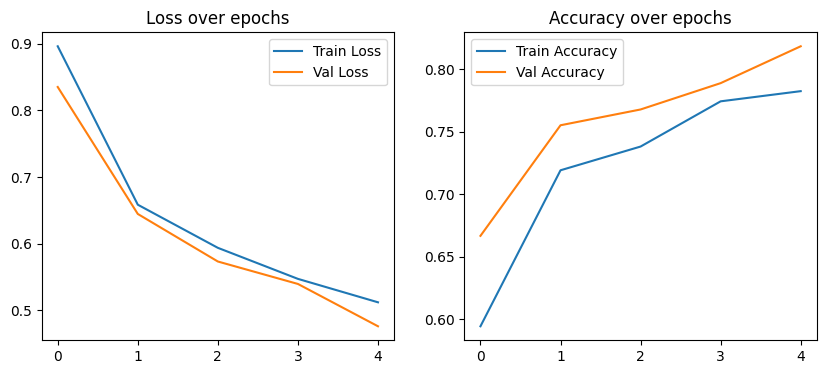

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

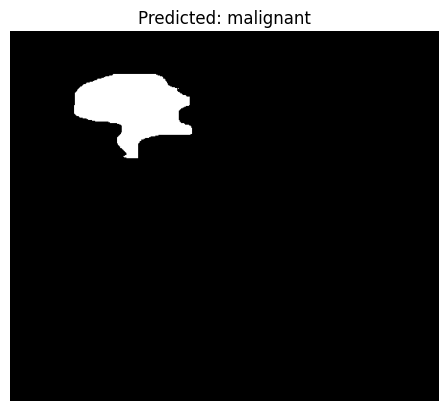

In [ ]:
from PIL import Image
import os
import glob

test_dir = '/content/drive/MyDrive/BUSI_split/test/malignant'

image_files = glob.glob(os.path.join(test_dir, '*.png')) + \
              glob.glob(os.path.join(test_dir, '*.jpg')) + \
              glob.glob(os.path.join(test_dir, '*.jpeg'))

if image_files:
    image_path = image_files[0]
    image = Image.open(image_path).convert('RGB')

    transform = val_transforms
    class_names = train_ds.classes

    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
        prediction = class_names[pred.item()]

    plt.imshow(image)
    plt.title(f"Predicted: {prediction}")
    plt.axis('off')
    plt.show()
else:
    print(f"No image files found in {test_dir}")

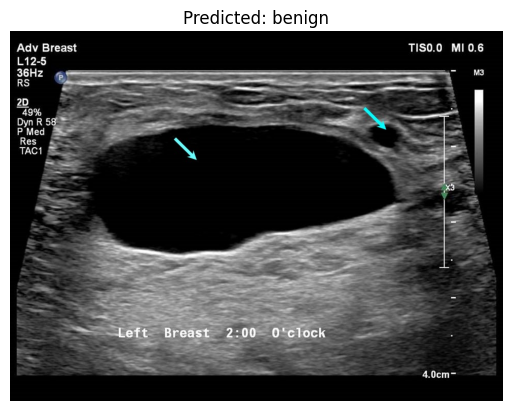

In [ ]:
from PIL import Image
image_path = '/content/5c7aa.jpg'
image = Image.open(image_path).convert('RGB')
img_tensor = transform(image).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    prediction = class_names[pred.item()]
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()